# Analyze der extract Daten

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

extract = '../01_data/chatbot_extract-1.csv'
names=['ticket', 'customer', 'complaint', 'state', 'answer']

corpus = pd.read_csv(extract, encoding='utf-8', names=names, skiprows=[0], usecols=[1, 2, 4, 5, 6])

# fix None value
corpus.complaint[67] = ''
corpus.head()

,ticket,customer,complaint,state,answer
0,Fehler in der App,Swissmem,"Normenauszug 2018, Rechenbuch Metall, Tabellen...",closed successful,"Mac: Access Denied -> Cookies, Virenscanner"
1,Fehler in der App,SVBA,Ich kann die Bilder nicht mehr öffnen um mit ...,closed successful,"Coupon einlösen, Produkte nicht vorhanden"
2,Fehler in der App,hep,Leider fehlen mir paar Kapitel im Lehrmittel (...,closed successful,"Mac: Access Denied -> Cookies, Virenscanner"
3,Anmeldung / Aktivierung,AGVS,Ich kann im FK z.b. die Seite 605 nicht lesen ...,closed successful,Linux
4,Anmeldung / Aktivierung,SVBA,Ich kann das Kapitel Technisches Englisch nich...,closed successful,"Coupon einlösen, Produkte nicht vorhanden"


### Verteilung
Die extract Daten sind nicht ausgewogen verteilt.

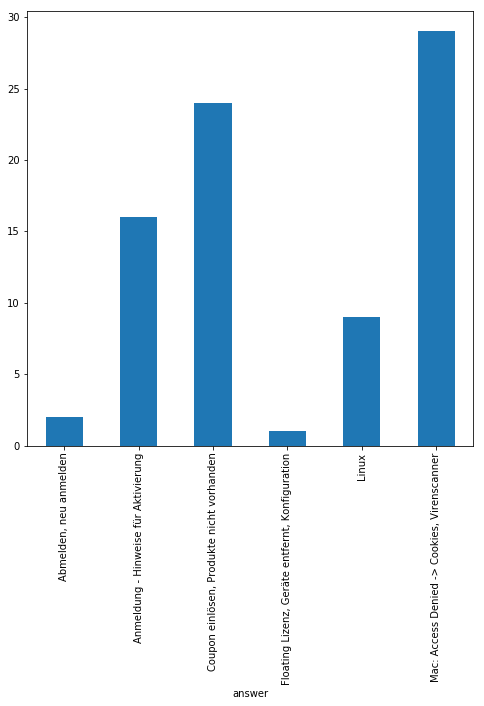

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
corpus.groupby('answer').complaint.count().plot.bar(ylim=0)
plt.show()

### Text pre-processing
Ab Zeile 60 gibt es irgendwo ein Problem mit dem Datentyp. Später anschauen.

In [4]:
import re
import nltk
import numpy as np

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('german')

def normalize_document(doc):
    # lower case and remove special characters \ whitespaces
    doc = re.sub(r'[^\u00C0-\u017Fa-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = wpt.tokenize(doc)
    
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [5]:
corpus.complaint = normalize_corpus(list(corpus.complaint.array))
corpus.head()

,ticket,customer,complaint,state,answer
0,Fehler in der App,Swissmem,normenauszug rechenbuch metall tabellenbuchs m...,closed successful,"Mac: Access Denied -> Cookies, Virenscanner"
1,Fehler in der App,SVBA,bilder mehr öffnen editorprogramm bearbeiten,closed successful,"Coupon einlösen, Produkte nicht vorhanden"
2,Fehler in der App,hep,leider fehlen paar kapitel lehrmittel lma d ei...,closed successful,"Mac: Access Denied -> Cookies, Virenscanner"
3,Anmeldung / Aktivierung,AGVS,fk zb seite lesen steht seiten auszugs genutzt,closed successful,Linux
4,Anmeldung / Aktivierung,SVBA,kapitel technisches englisch herunterladen ste...,closed successful,"Coupon einlösen, Produkte nicht vorhanden"


### Text repräsentation
Hier ist zu sehen wi 81 Support Anfragen durch 26 features repräsentiert werden. Schöner wäre -> 81 Support Anfragen durch 240 features zu repräsentieren.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words=['zb']
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words=stop_words)

features = tfidf.fit_transform(corpus.complaint).toarray()
labels = corpus.answer
features.shape

(81, 26)

In [7]:
corpus['answer_id'] = corpus['answer'].factorize()[0]
answer_id_df = corpus[['answer', 'answer_id']].drop_duplicates().sort_values('answer_id')
answer_to_id = dict(answer_id_df.values)
id_to_answer = dict(answer_id_df[['answer_id', 'answer']].values)

answer_id_df

,answer,answer_id
0,"Mac: Access Denied -> Cookies, Virenscanner",0
1,"Coupon einlösen, Produkte nicht vorhanden",1
3,Linux,2
28,Anmeldung - Hinweise für Aktivierung,3
40,"Abmelden, neu anmelden",4
64,"Floating Lizenz, Geräte entfernt, Konfiguration",5


### naive bayes

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(corpus['complaint'], corpus['answer'], random_state = 0)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [9]:
print(clf.predict(count_vect.transform(
    ['''
        Ich kann die Dateien nicht mehr öffnen um mit dem Editorprogramm diese zu bearbeiten.
    ''']
)))

['Coupon einlösen, Produkte nicht vorhanden']


In [10]:
print(clf.predict(count_vect.transform(
    ['''
        Ich kann im FK z.b. die Seite 605 nicht lesen weil da steht, Alle Seiten des Auszugs sind genutzt.
    ''']
)))

['Coupon einlösen, Produkte nicht vorhanden']


### Model evaluation

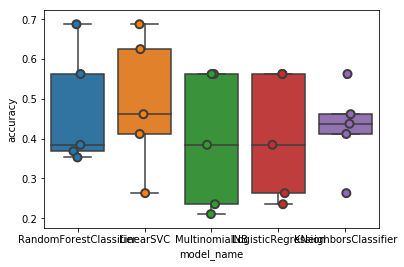

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, multi_class='auto', solver='lbfgs'),
    KNeighborsClassifier(n_neighbors=3)
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [12]:
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.427292
LinearSVC                 0.489792
LogisticRegression        0.401613
MultinomialNB             0.391087
RandomForestClassifier    0.471196
Name: accuracy, dtype: float64

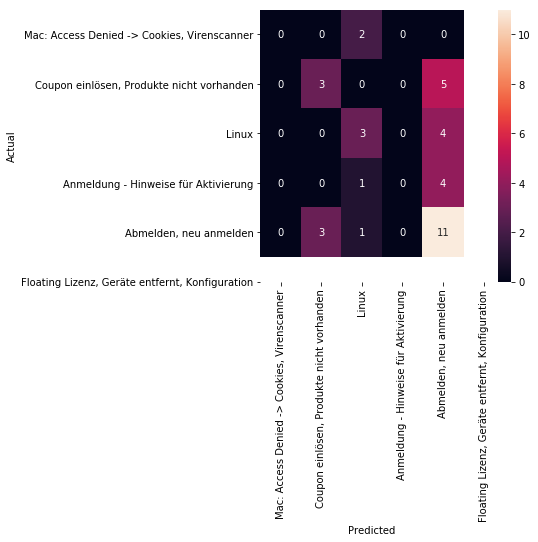

In [13]:
model = KNeighborsClassifier(n_neighbors=3)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus.index, test_size=0.45, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=answer_id_df.answer.values, yticklabels=answer_id_df.answer.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

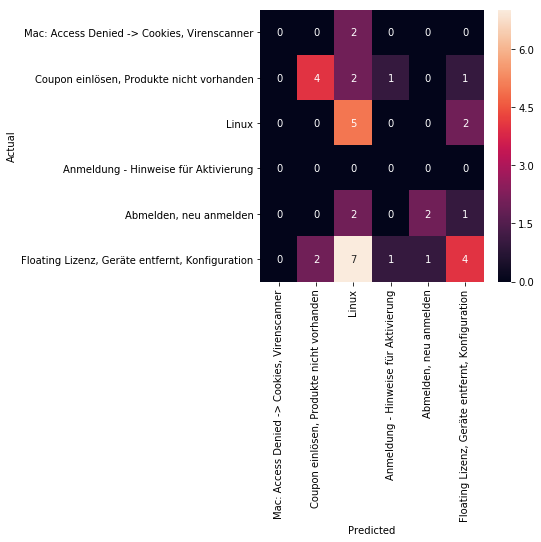

In [14]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus.index, test_size=0.45, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=answer_id_df.answer.values, yticklabels=answer_id_df.answer.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

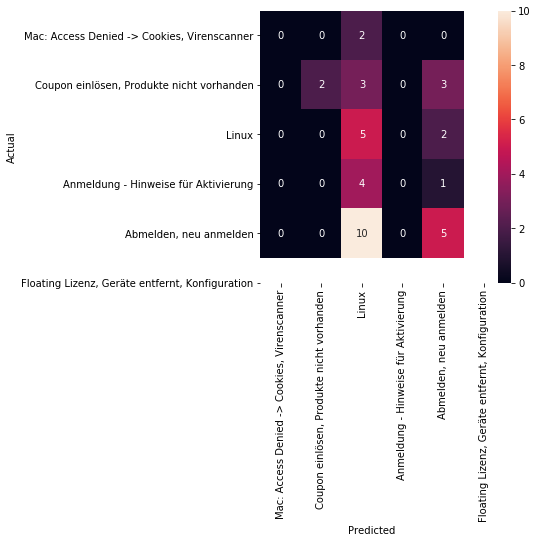

In [15]:
model = LogisticRegression(random_state=0, multi_class='auto', solver='lbfgs')

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus.index, test_size=0.45, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=answer_id_df.answer.values, yticklabels=answer_id_df.answer.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

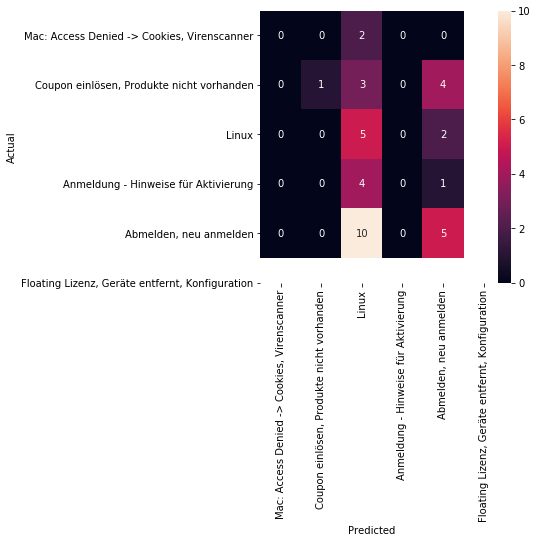

In [16]:
model = MultinomialNB()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus.index, test_size=0.45, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=answer_id_df.answer.values, yticklabels=answer_id_df.answer.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

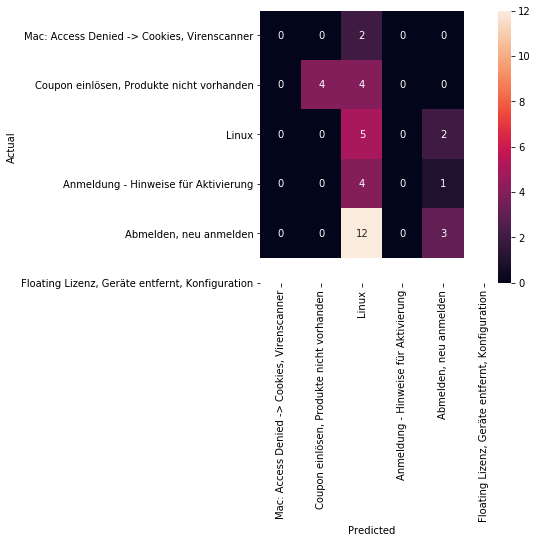

In [17]:
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus.index, test_size=0.45, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=answer_id_df.answer.values, yticklabels=answer_id_df.answer.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()